In [0]:
!nvidia-smi

Sun Dec 22 09:17:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.3)


In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import albumentations as A
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [0]:
!gdown --id 1rZX15GYUJ44kEiuZOPUL4quOjcqwi-f5 --output documents.zip

Downloading...
From: https://drive.google.com/uc?id=1rZX15GYUJ44kEiuZOPUL4quOjcqwi-f5
To: /content/documents.zip
100% 438k/438k [00:00<00:00, 60.2MB/s]


In [0]:
!unzip -q documents.zip

In [0]:
!ls

documents.zip  form.png  license.jpeg  sample_data


In [0]:
BOX_COLOR = (255, 0, 0)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

In [0]:
def show_image(image, bbox):
  image = visualize_bbox(image.copy(), bbox)
  f = plt.figure(figsize=(18, 12))
  plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
  )
  plt.axis('off')
  f.tight_layout()
  plt.show()

In [0]:
form = cv2.imread("form.png")
STUDENT_ID_BBOX = [140, 260, 300, 300]

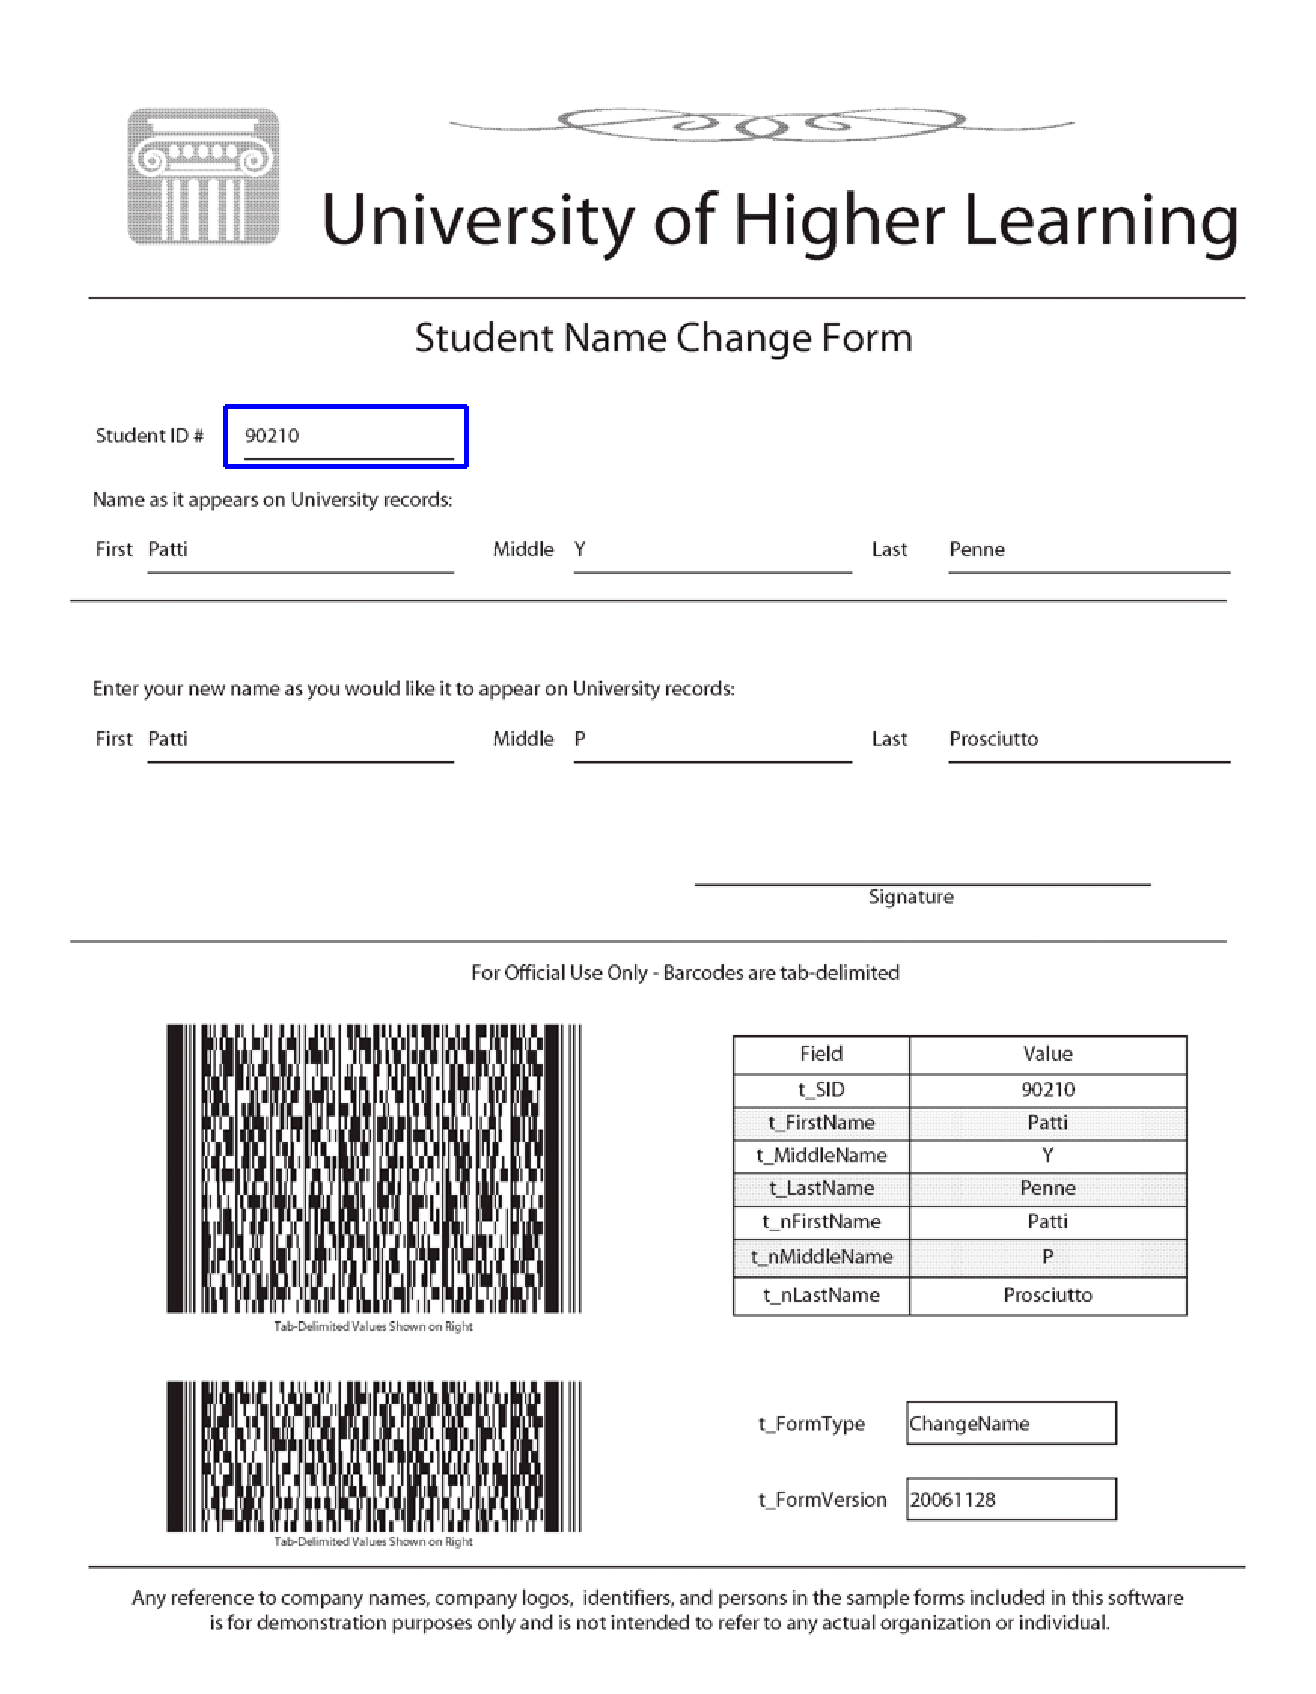

In [0]:
show_image(form, bbox=STUDENT_ID_BBOX)

In [0]:
def show_augmented(augmentation, image, bbox):
  augmented = augmentation(image=image, bboxes=[bbox], field_id=['1'])
  show_image(augmented['image'], augmented['bboxes'][0])

In [0]:
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

# Exploring Augmentations

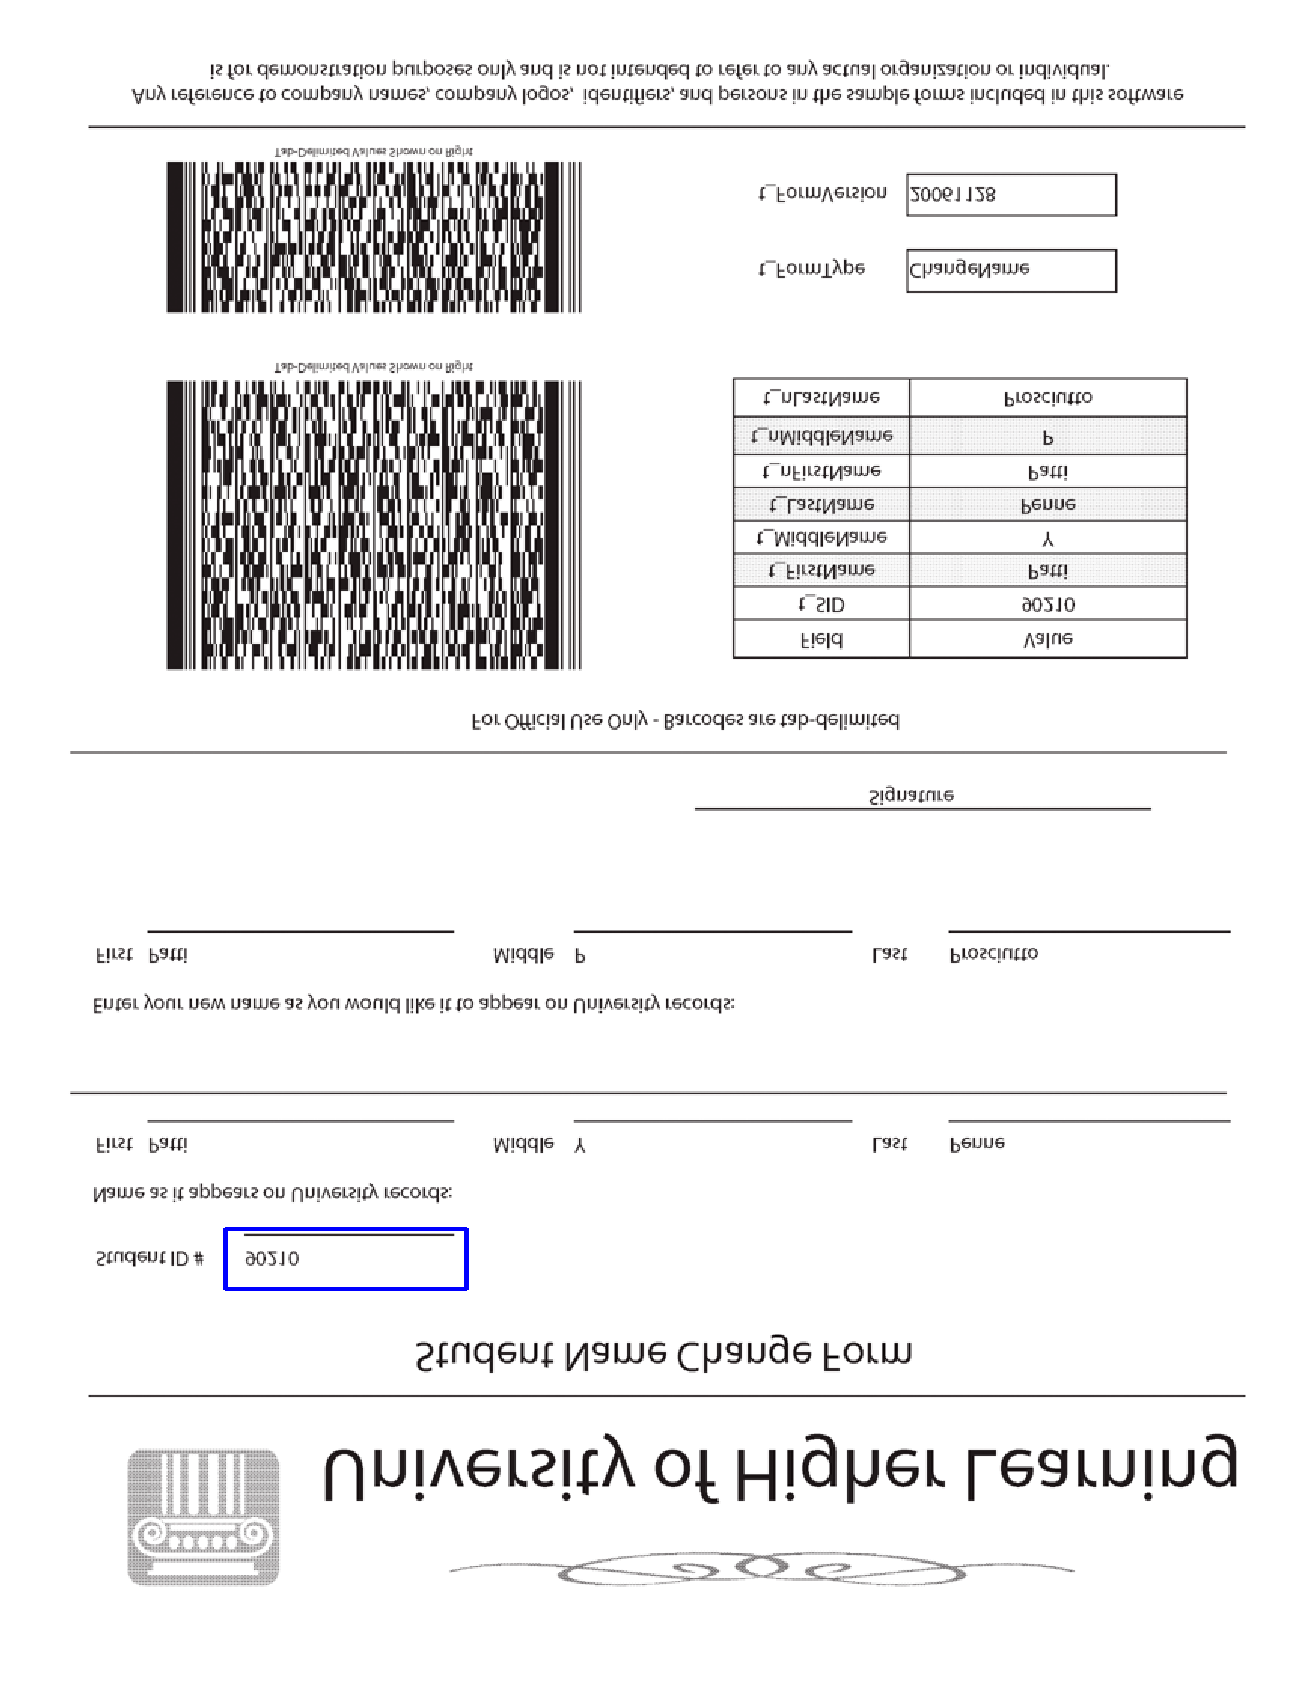

In [0]:
aug = A.Compose([
    A.Flip(always_apply=True)
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

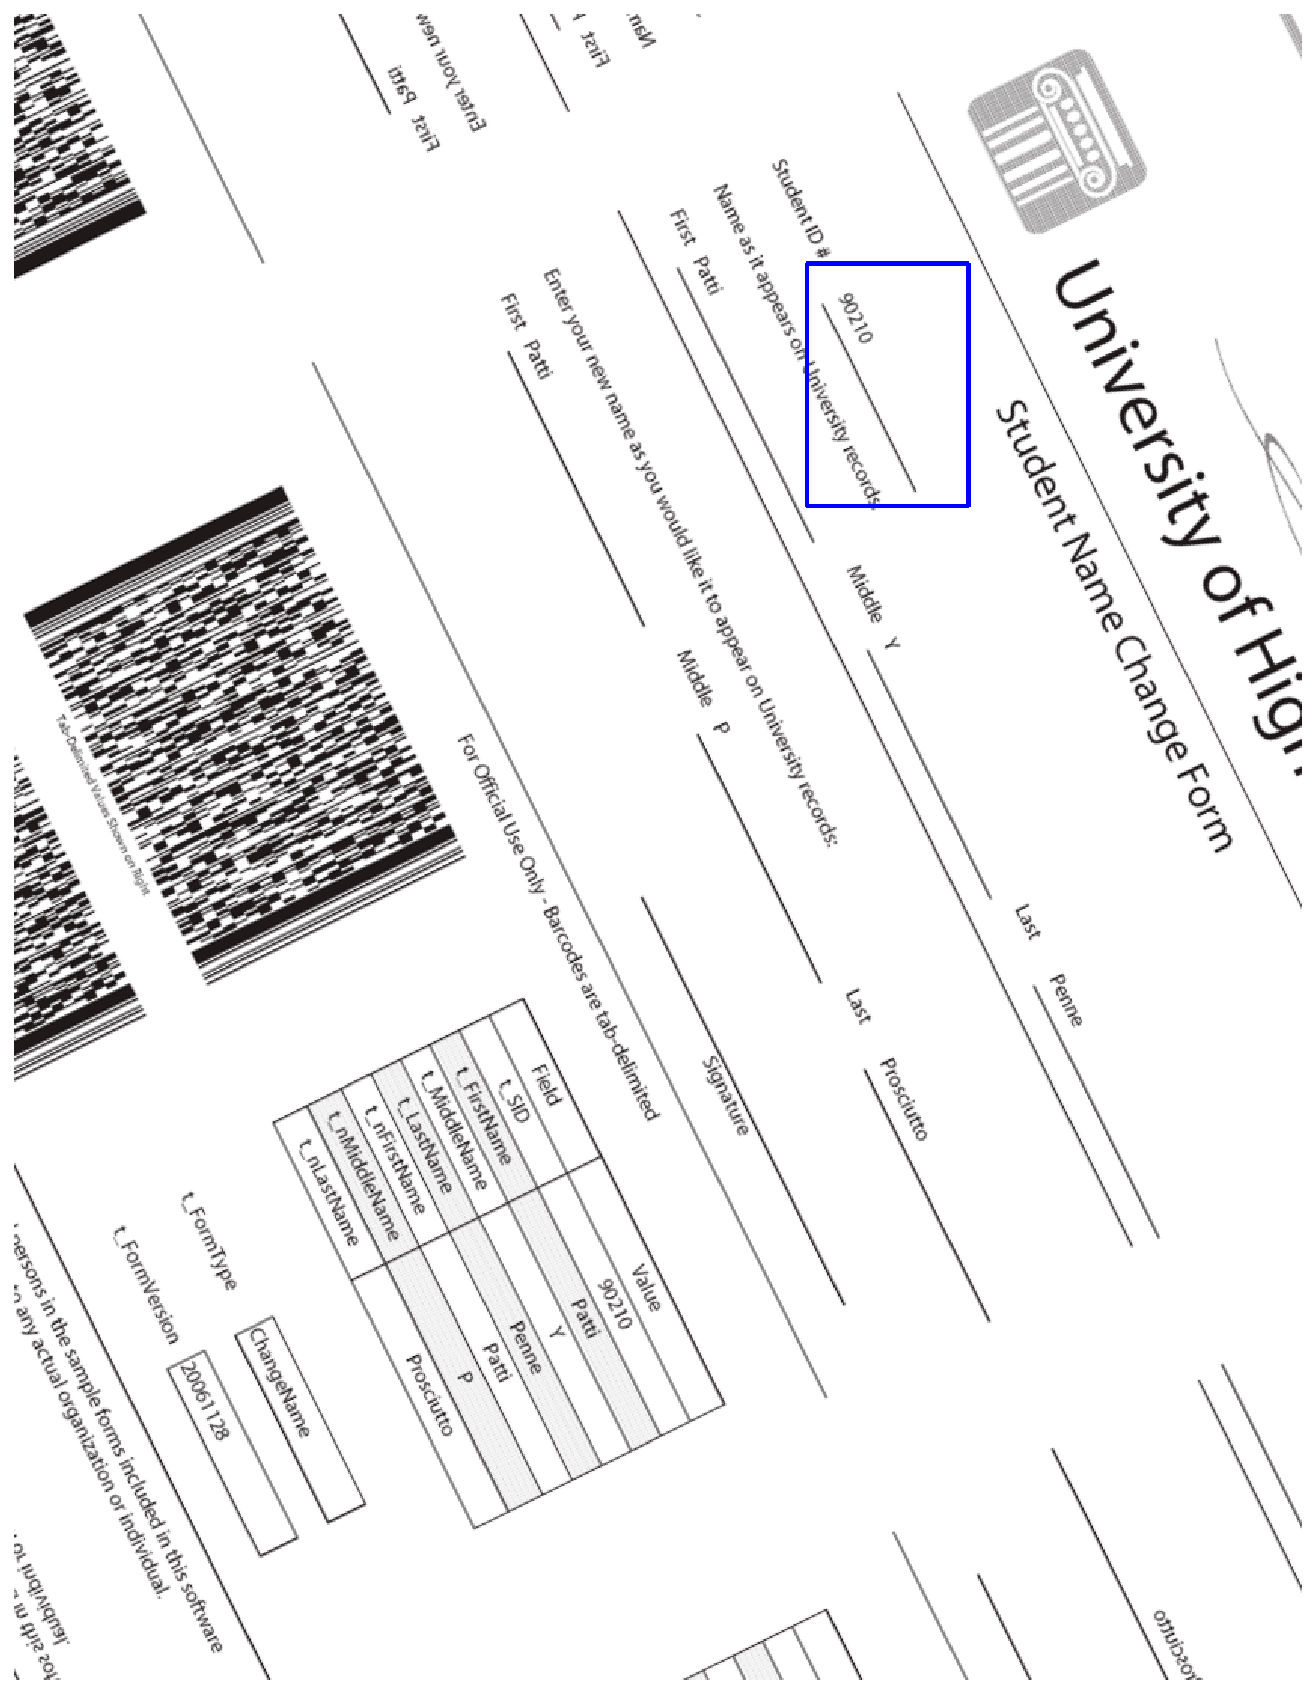

In [0]:
aug = A.Compose([
  A.Rotate(limit=80, always_apply=True)
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

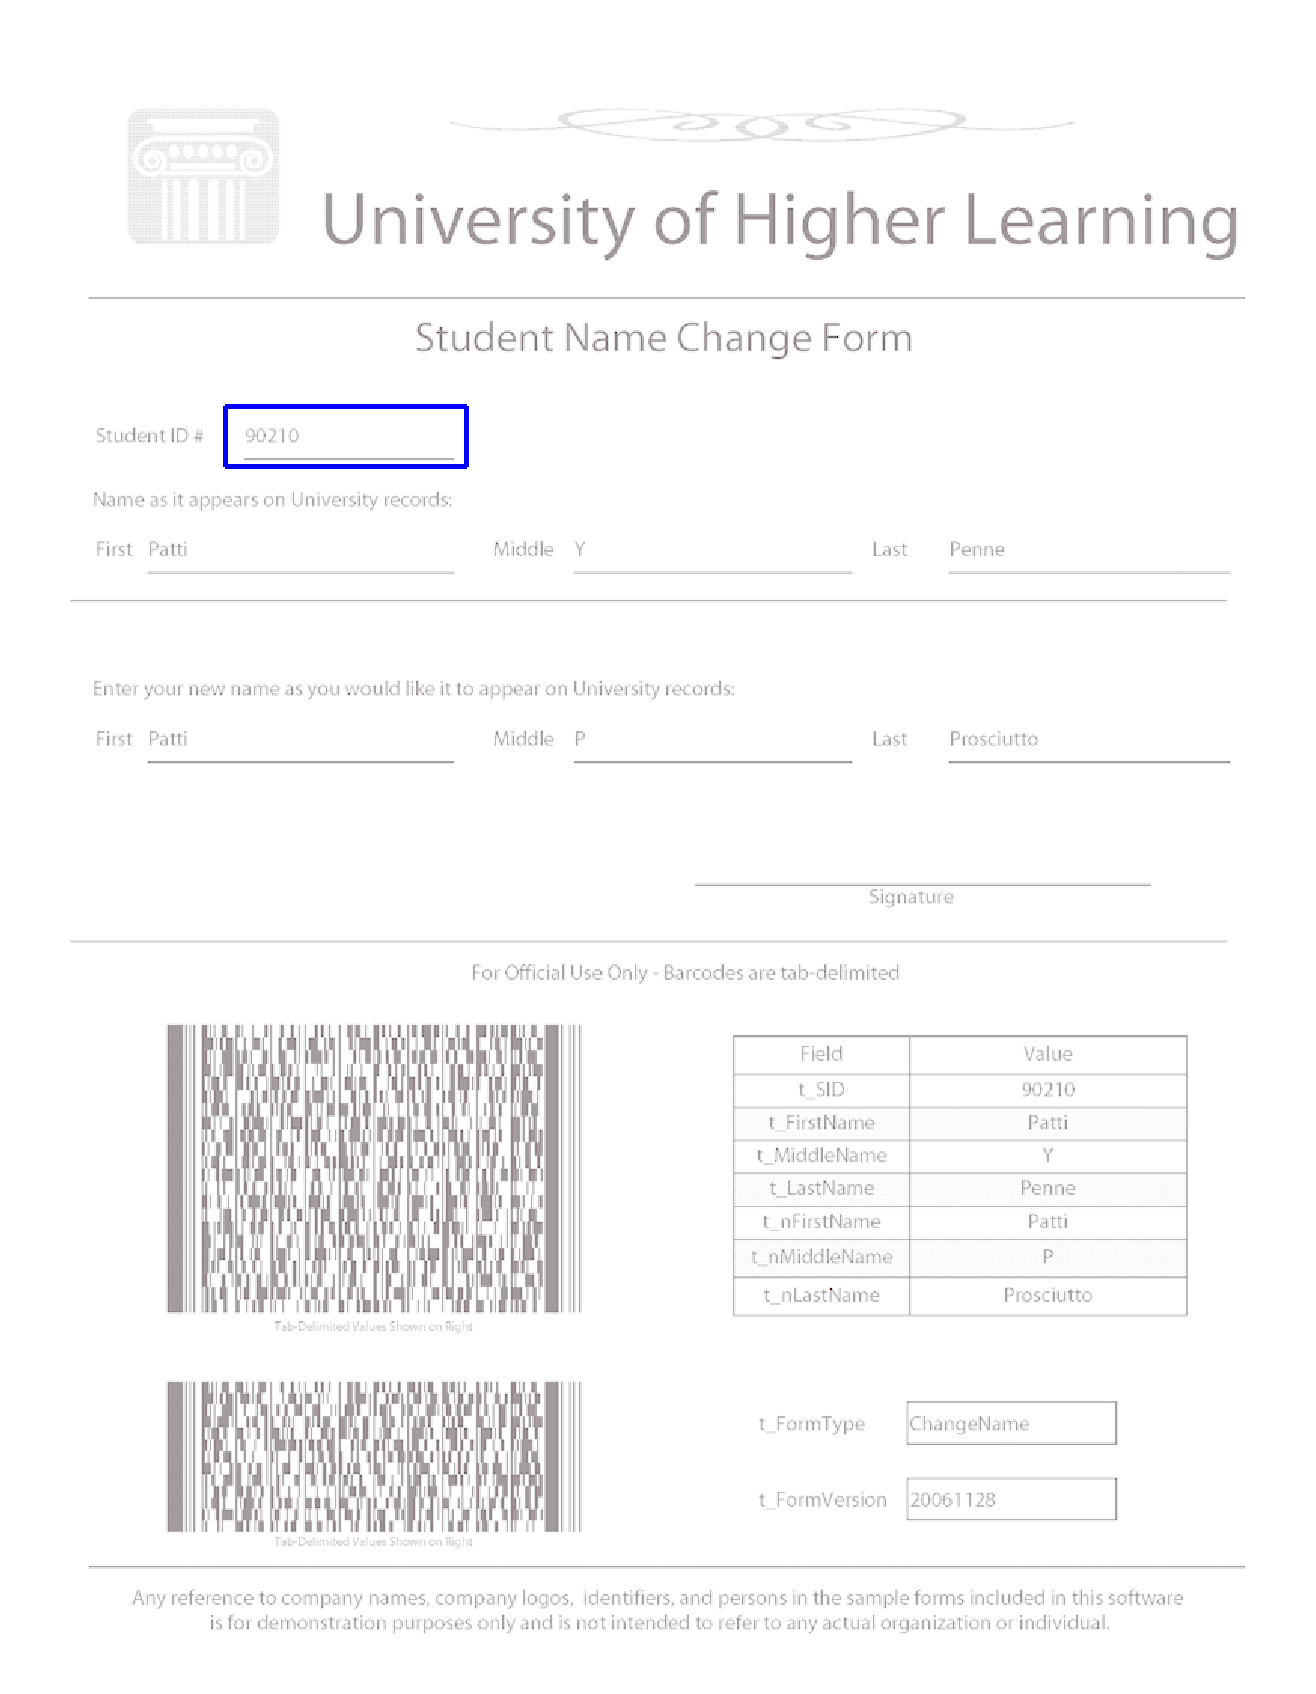

In [0]:
aug = A.Compose([
    A.RandomGamma(gamma_limit=(400, 500), always_apply=True)
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

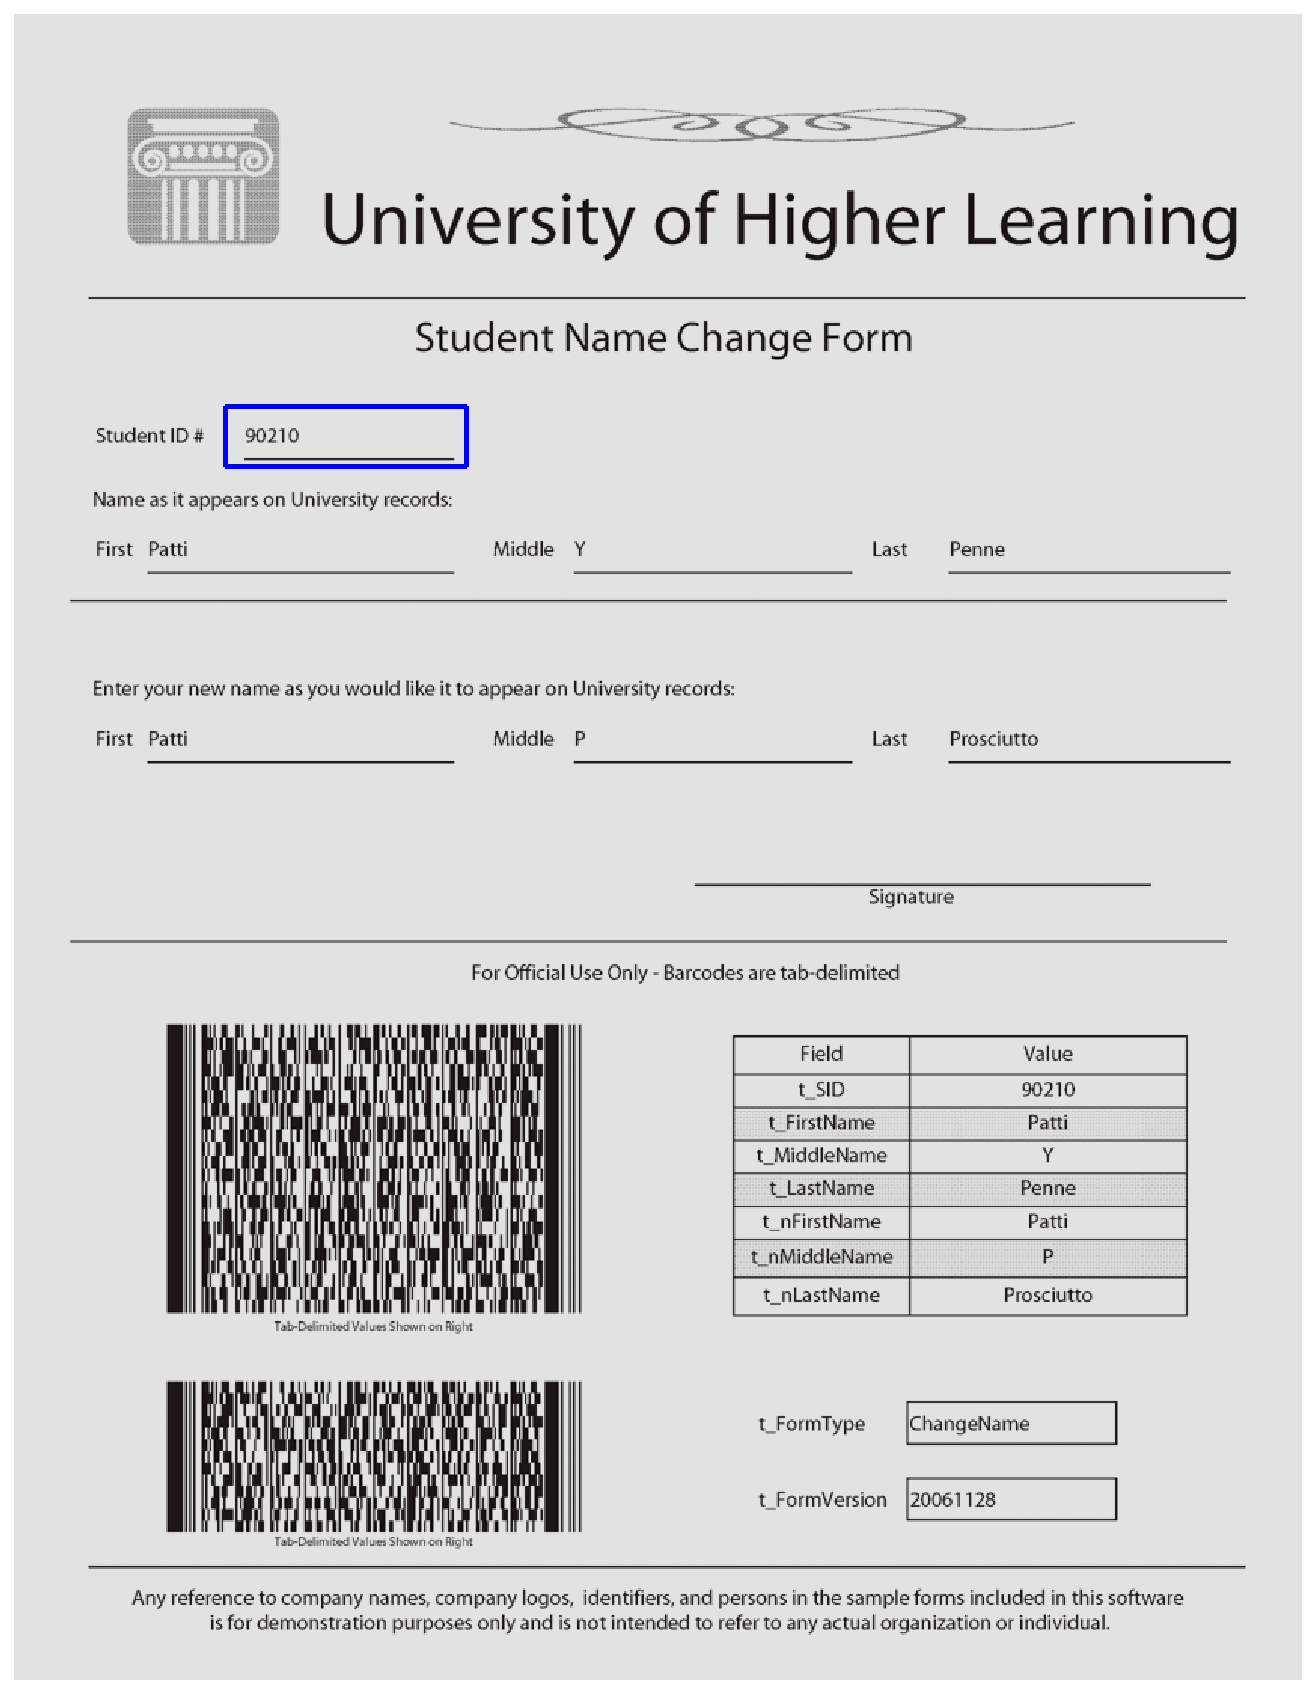

In [0]:
aug = A.Compose([
    A.RandomBrightnessContrast(always_apply=True),
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

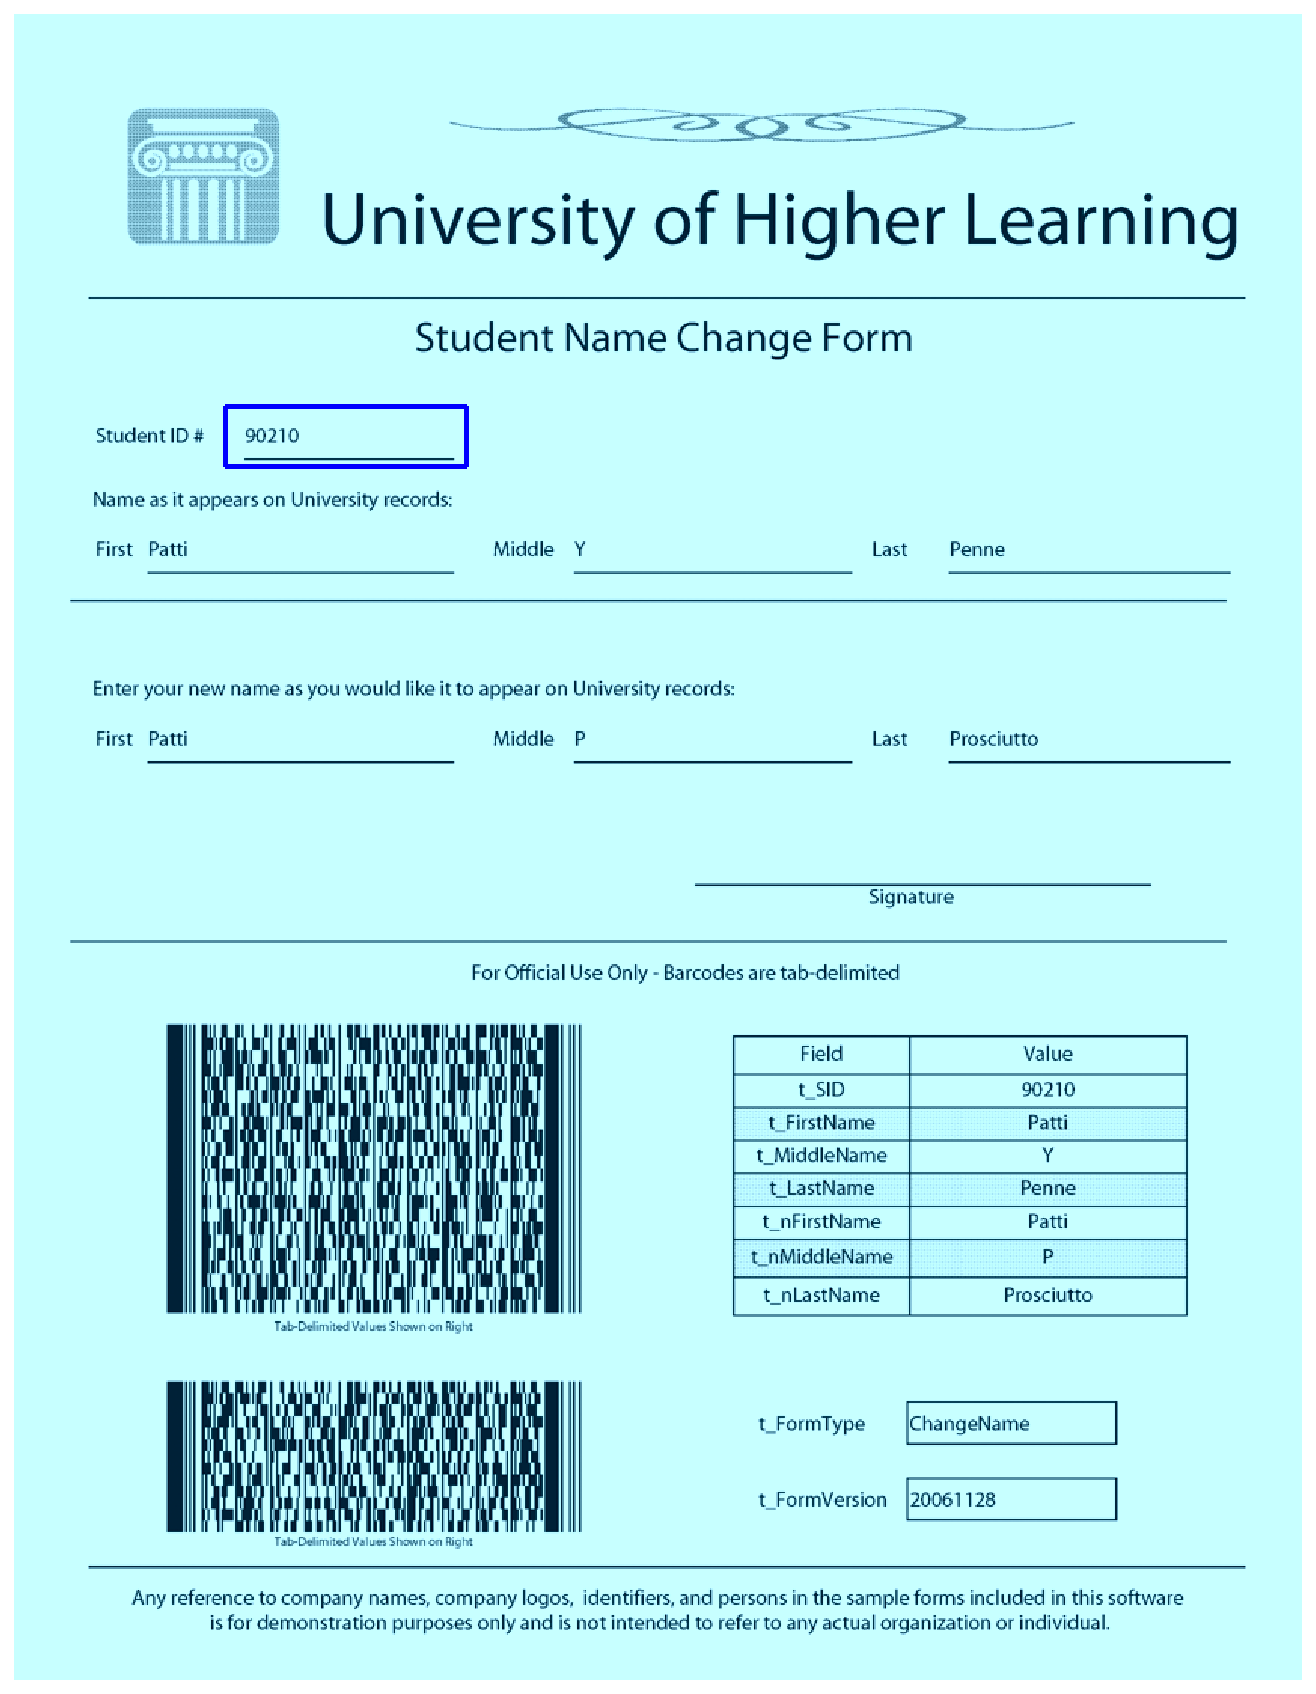

In [0]:
aug = A.Compose([
    A.RGBShift(
      always_apply=True, 
      r_shift_limit=100, 
      g_shift_limit=100,
      b_shift_limit=100
    ),
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

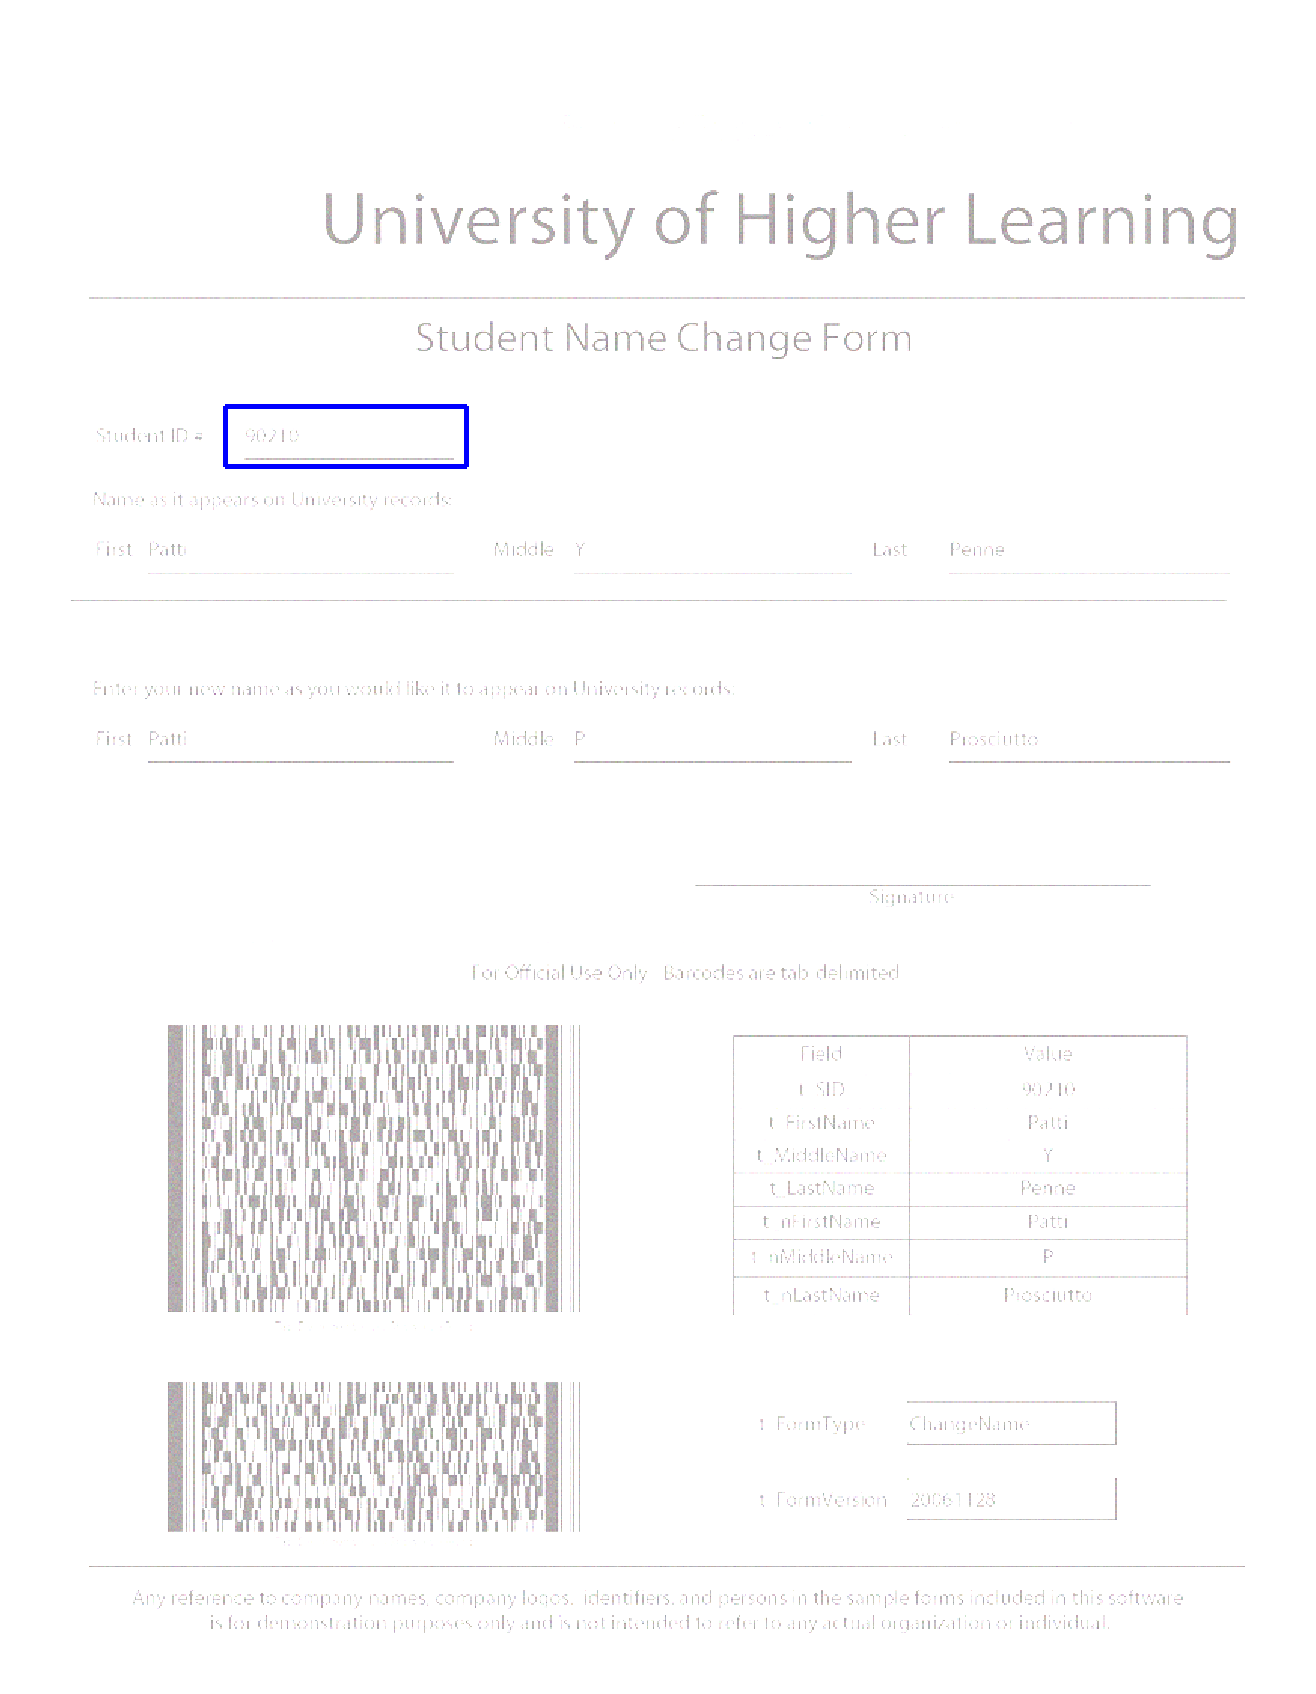

In [0]:
aug = A.Compose([
    A.GaussNoise(
      always_apply=True,
      var_limit=(100, 300),
      mean=150
    ),
], bbox_params=bbox_params)

show_augmented(aug, form, STUDENT_ID_BBOX)

# Augmenting Scanned Documents

In [0]:
doc_aug = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.RGBShift(p=0.75),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

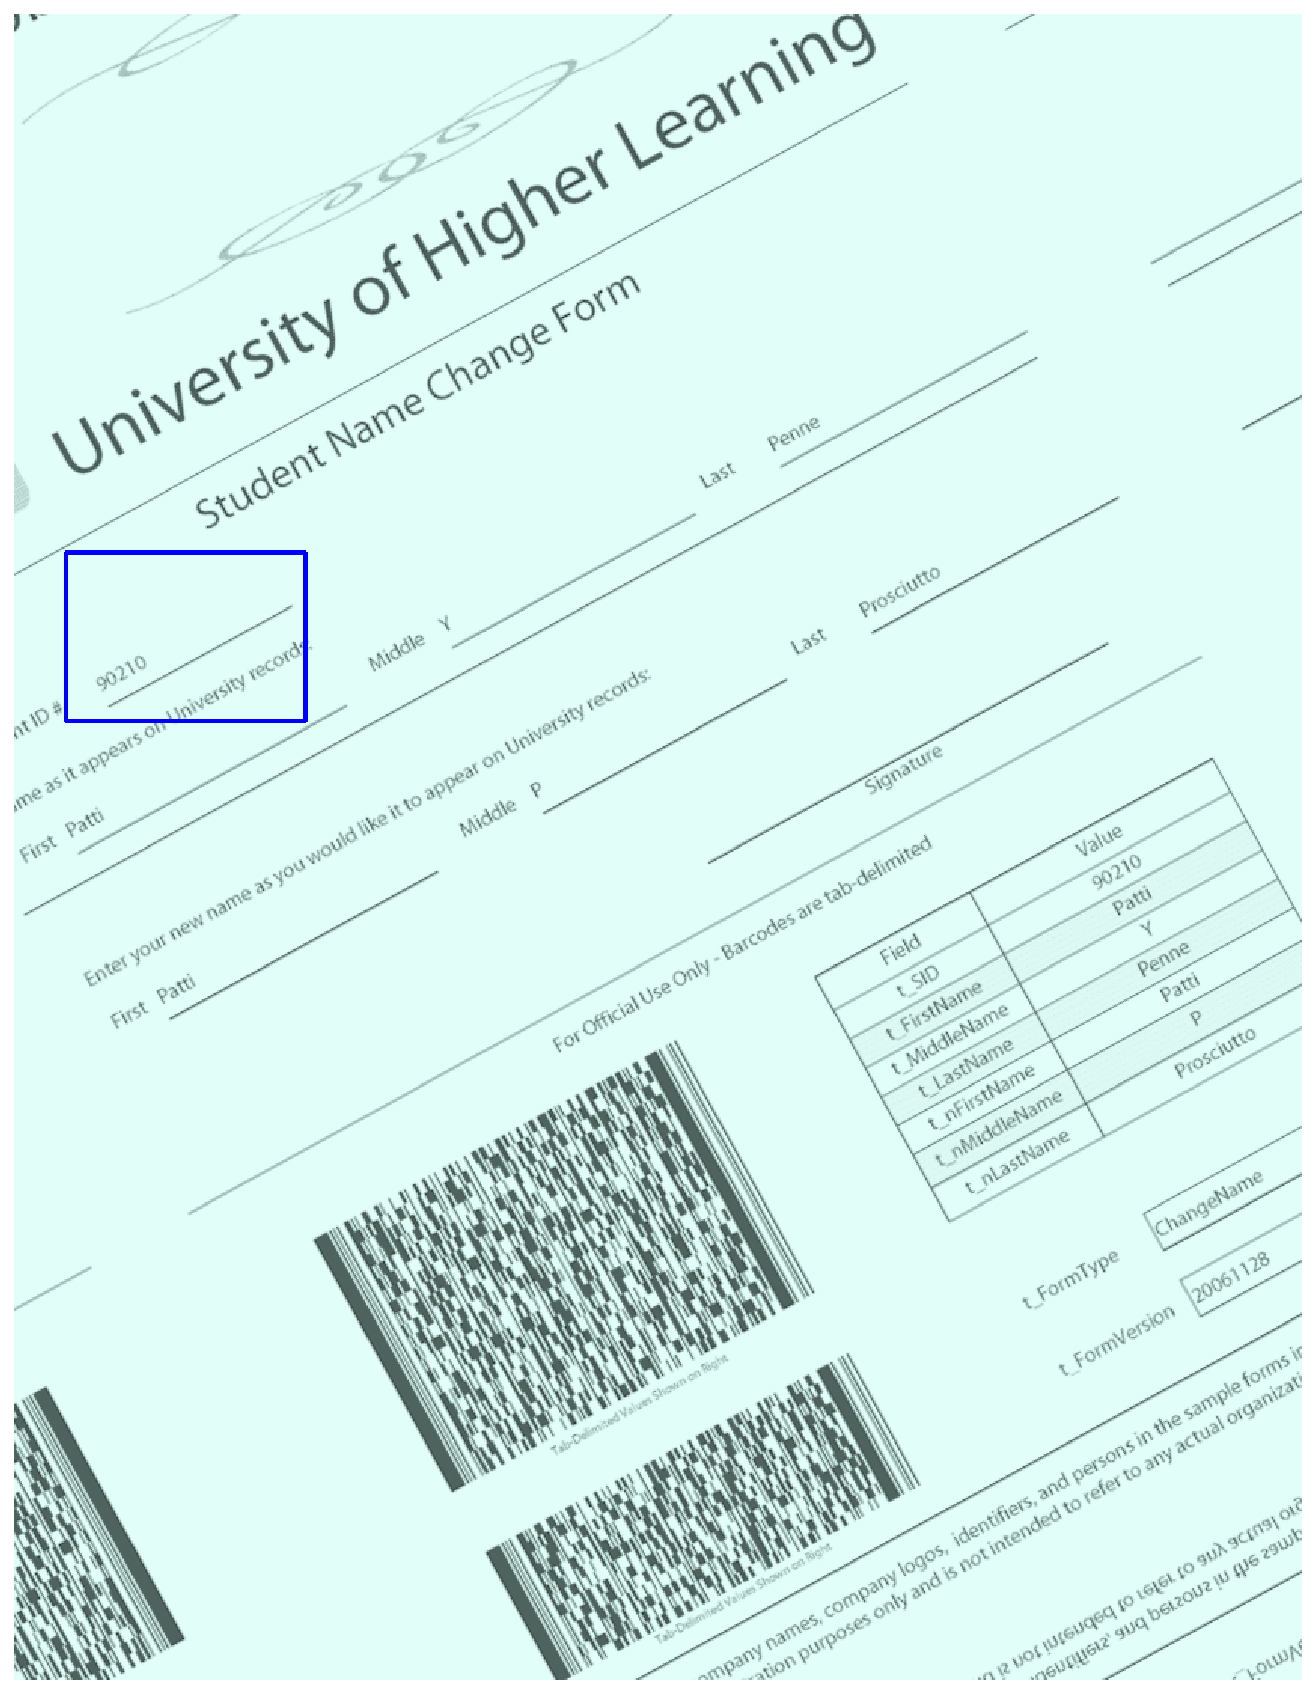

In [0]:
show_augmented(doc_aug, form, STUDENT_ID_BBOX)


# Creating Augmented Dataset

Using the format:

`path/to/image.jpg,x1,y1,x2,y2,class_name`

In [0]:
DATASET_PATH = 'data/augmented'
IMAGES_PATH = f'{DATASET_PATH}/images'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []
for i in tqdm(range(100)):
  augmented = doc_aug(image=form, bboxes=[STUDENT_ID_BBOX], field_id=['1'])
  file_name = f'form_aug_{i}.jpg'
  for bbox in augmented['bboxes']:
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    rows.append({
      'file_name': f'images/{file_name}',
      'x_min': x_min,
      'y_min': y_min,
      'x_max': x_max,
      'y_max': y_max,
      'class': 'student_id'
    })

  cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

pd.DataFrame(rows).to_csv(f'{DATASET_PATH}/annotations.csv', header=True, index=None)

100%|██████████| 100/100 [00:07<00:00,  9.22it/s]
